## Import Necessary Libraries and Load the Data

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [70]:
df = pd.read_csv("Walmart_Sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [72]:
df.duplicated().sum()

0

In [73]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [74]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


## Exploratory Data Analysis

In [76]:
columns_to_describe = [col for col in df.columns if col not in ['Store','Date','Holiday_Flag']]
max_sales_record = df.loc[df['Weekly_Sales'].idxmax()]

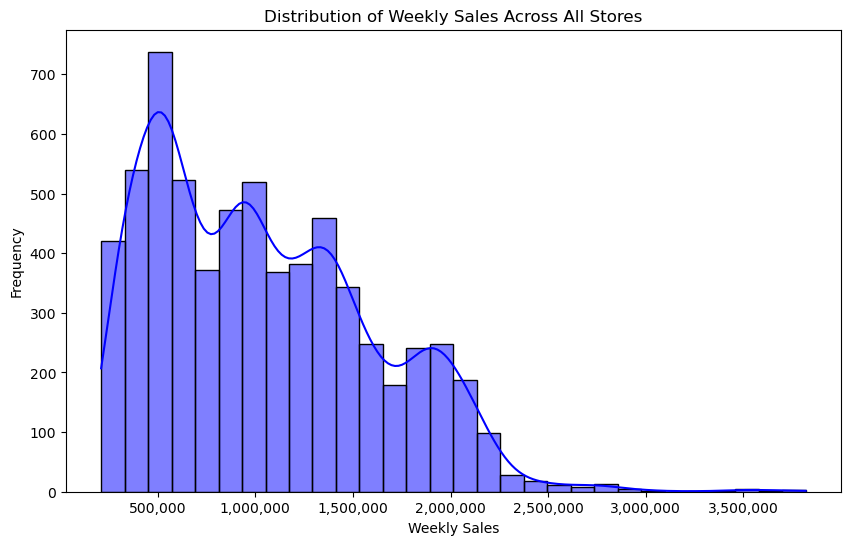

In [77]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], kde=True, bins=30, color='blue')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,}'.format(int(x))))
plt.title("Distribution of Weekly Sales Across All Stores")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.savefig('distribution.png', transparent=True)
plt.show()

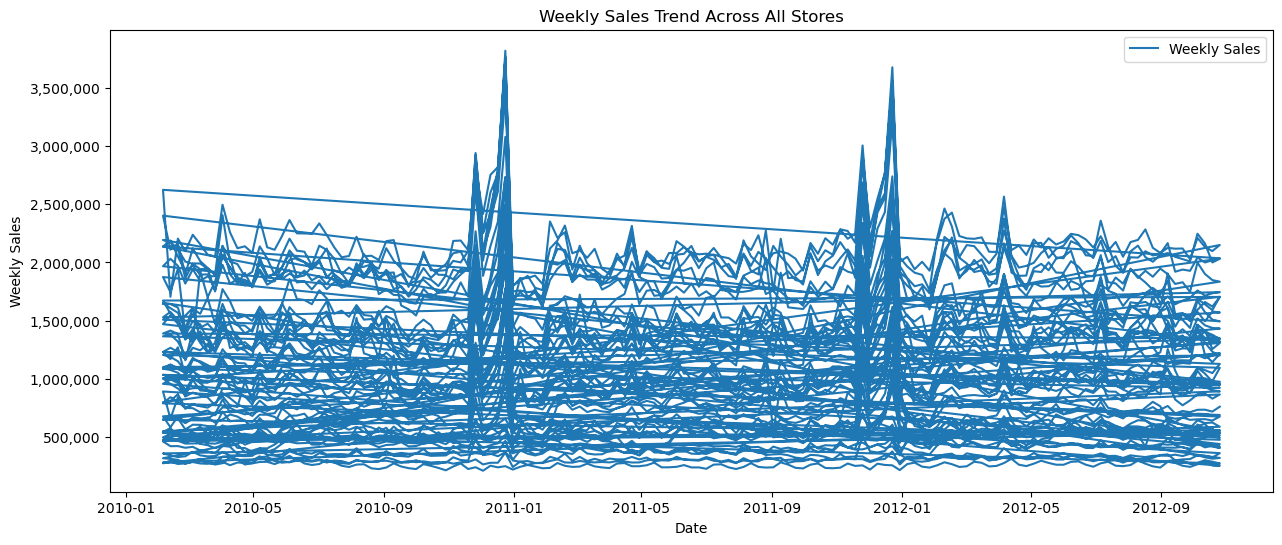

In [78]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Weekly_Sales'], label='Weekly Sales')
plt.title("Weekly Sales Trend Across All Stores")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,}'.format(int(y))))
plt.ylabel("Weekly Sales")
plt.legend()
plt.savefig('trend.png', transparent=True)
plt.show()

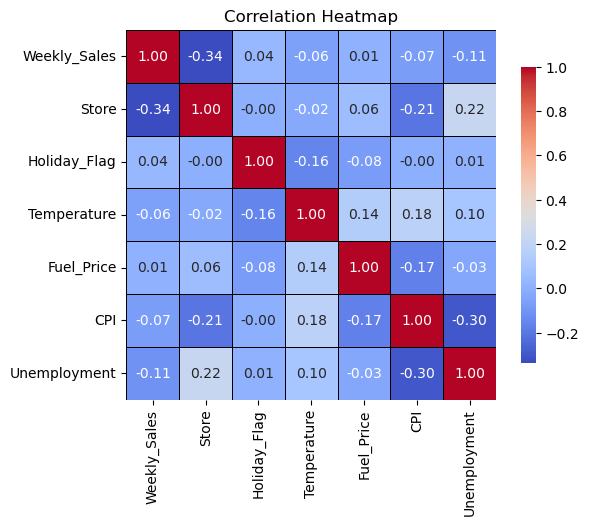

In [79]:
corr_matrix = df[['Weekly_Sales', 'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', square=True, cbar_kws={"shrink": .8},linewidths=.5, linecolor='black')
plt.title("Correlation Heatmap")
plt.savefig('correlation.png', transparent=True)
plt.show()

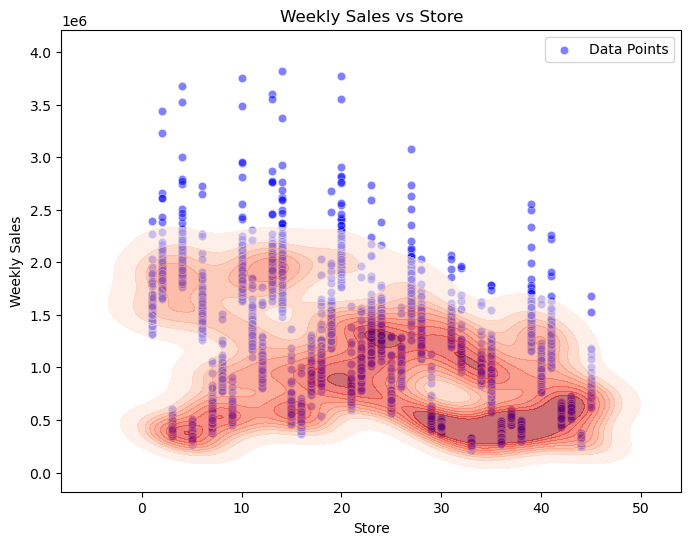

In [80]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Store'], y=df['Weekly_Sales'], alpha=0.5, color='blue', label='Data Points')
sns.kdeplot(x=df['Store'], y=df['Weekly_Sales'], cmap='Reds', fill=True, alpha=0.6, label='Density')
plt.title('Weekly Sales vs Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.legend()
plt.savefig('store_vs_weekly_sales.png', transparent=True)
plt.show()

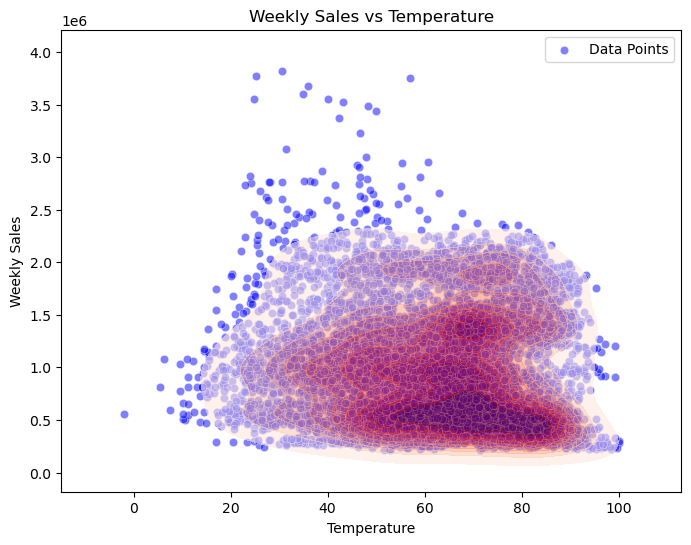

In [81]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Temperature'], y=df['Weekly_Sales'], alpha=0.5, color='blue', label='Data Points')
sns.kdeplot(x=df['Temperature'], y=df['Weekly_Sales'], cmap='Reds', fill=True, alpha=0.6, label='Density')
plt.title('Weekly Sales vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.legend()
plt.savefig('temperature_vs_weekly_sales.png', transparent=True)
plt.show()

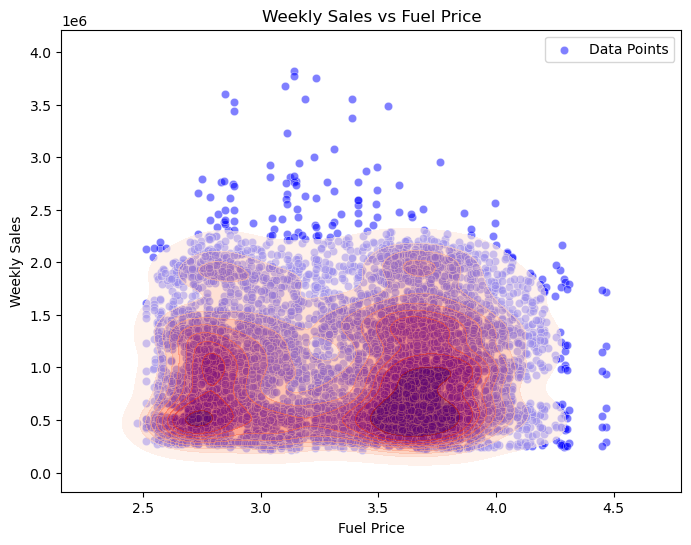

In [82]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Fuel_Price'], y=df['Weekly_Sales'], alpha=0.5, color='blue', label='Data Points')
sns.kdeplot(x=df['Fuel_Price'], y=df['Weekly_Sales'], cmap='Reds', fill=True, alpha=0.6, label='Density')
plt.title('Weekly Sales vs Fuel Price')
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.legend()
plt.savefig('fuel_price_vs_weekly_sales.png', transparent=True)
plt.show()

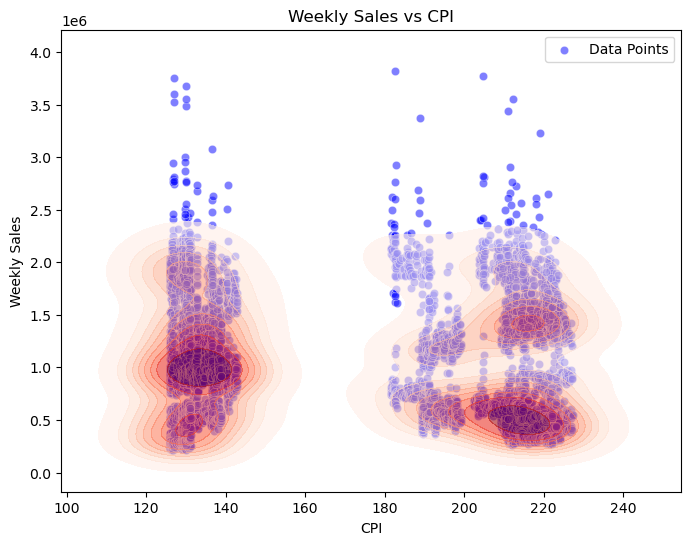

In [83]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['CPI'], y=df['Weekly_Sales'], alpha=0.5, color='blue', label='Data Points')
sns.kdeplot(x=df['CPI'], y=df['Weekly_Sales'], cmap='Reds', fill=True, alpha=0.6, label='Density')
plt.title('Weekly Sales vs CPI')
plt.xlabel('CPI')
plt.ylabel('Weekly Sales')
plt.legend()
plt.savefig('cpi_vs_weekly_sales.png', transparent=True)
plt.show()

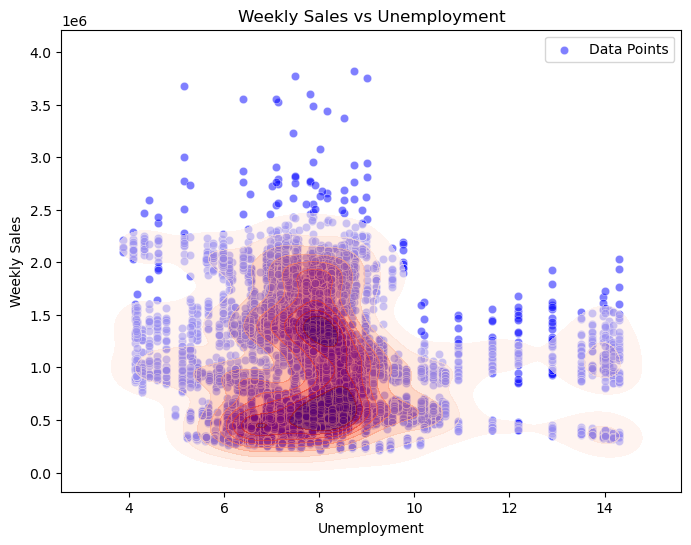

In [84]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Unemployment'], y=df['Weekly_Sales'], alpha=0.5, color='blue', label='Data Points')
sns.kdeplot(x=df['Unemployment'], y=df['Weekly_Sales'], cmap='Reds', fill=True, alpha=0.6, label='Density')
plt.title('Weekly Sales vs Unemployment')
plt.xlabel('Unemployment')
plt.ylabel('Weekly Sales')
plt.legend()
plt.savefig('unemployment_vs_weekly_sales.png', transparent=True)
plt.show()

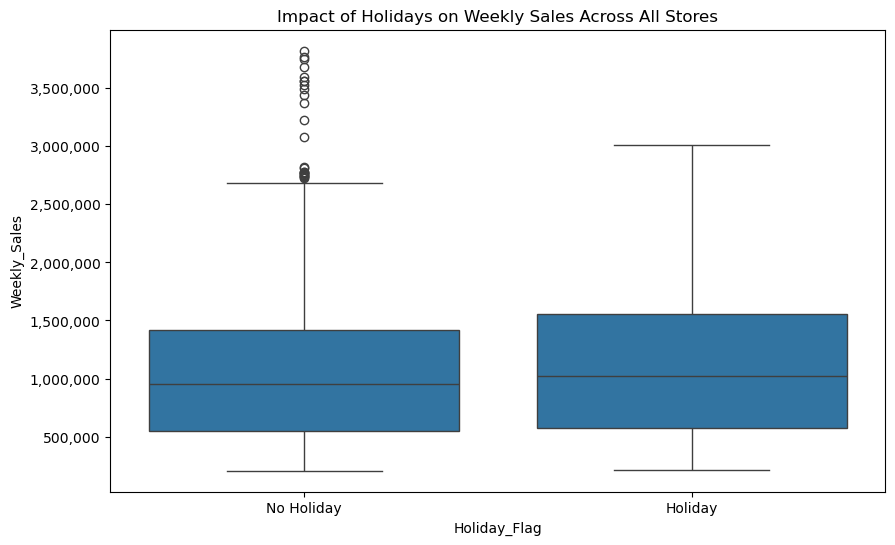

In [85]:
plt.figure(figsize=(10, 6))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,}'.format(int(y))))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title("Impact of Holidays on Weekly Sales Across All Stores")
plt.xticks([0, 1], ['No Holiday', 'Holiday'])
plt.savefig('holiday.png', transparent=True)
plt.show()

In [86]:
max_sales_record = df.loc[df['Weekly_Sales'].idxmax()]
print(max_sales_record)

Store                            14
Date            2010-12-24 00:00:00
Weekly_Sales             3818686.45
Holiday_Flag                      0
Temperature                   30.59
Fuel_Price                    3.141
CPI                       182.54459
Unemployment                  8.724
Name: 1905, dtype: object


In [87]:
min_sales_record = df.loc[df['Weekly_Sales'].idxmin()]
print(min_sales_record)

Store                            33
Date            2010-12-03 00:00:00
Weekly_Sales              209986.25
Holiday_Flag                      0
Temperature                   52.82
Fuel_Price                    3.041
CPI                      126.731333
Unemployment                  9.265
Name: 4619, dtype: object


In [88]:
df[columns_to_describe].describe()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,7.999151
std,5.643666e+05,18.444933,0.459020,39.356712,1.875885
min,2.099862e+05,-2.060000,2.472000,126.064000,3.879000
25%,5.533501e+05,47.460000,2.933000,131.735000,6.891000
50%,9.607460e+05,62.670000,3.445000,182.616521,7.874000
75%,1.420159e+06,74.940000,3.735000,212.743293,8.622000
max,3.818686e+06,100.140000,4.468000,227.232807,14.313000


## Feature Engineering

In [89]:
# Extract time-related features
df['Week_of_Year'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

In [90]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week_of_Year,Month,Quarter
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,1
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,1
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,1
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,1
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,1


In [91]:
# Apply one-hot encoding to 'Store', 'Month' and 'Quarter'
df = pd.get_dummies(df, columns=['Store', 'Month', 'Quarter'], drop_first=False)

# Convert the boolean values (True/False) to integers (1/0)
for col in df.columns:
    if 'Store_' in col or 'Month_' in col or 'Quarter_' in col:
        df[col] = df[col].astype(int)

In [92]:
print(df.head())

        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0 2010-02-05    1643690.90             0        42.31       2.572  211.096358   
1 2010-02-12    1641957.44             1        38.51       2.548  211.242170   
2 2010-02-19    1611968.17             0        39.93       2.514  211.289143   
3 2010-02-26    1409727.59             0        46.63       2.561  211.319643   
4 2010-03-05    1554806.68             0        46.50       2.625  211.350143   

   Unemployment  Week_of_Year  Store_1  Store_2  ...  Month_7  Month_8  \
0         8.106             5        1        0  ...        0        0   
1         8.106             6        1        0  ...        0        0   
2         8.106             7        1        0  ...        0        0   
3         8.106             8        1        0  ...        0        0   
4         8.106             9        1        0  ...        0        0   

   Month_9  Month_10  Month_11  Month_12  Quarter_1  Quarter_2  Quar

## Split the Data

In [93]:
# Define the features
features = (
    [col for col in df.columns if col.startswith('Month_')] +  # Add one-hot encoded 'Month' columns
    [col for col in df.columns if col.startswith('Quarter_')] +  # Add one-hot encoded 'Quarter' columns
    [col for col in df.columns if col.startswith('Store_')] +  # Add one-hot encoded 'Store' columns
    ['Week_of_Year', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']  # Add the rest
)

# Define the target
target = 'Weekly_Sales'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Scale the Data

In [94]:
# Min-Max Scaling for features and target
scaler_X = MinMaxScaler()

# Scale the training features and apply the scaling to the test features
X_train_scaled = scaler_X.fit_transform(X_train) # Fit and transform on training data
X_test_scaled = scaler_X.transform(X_test) # Transform test data using the same scaler

scaler_y = MinMaxScaler()

# Reshape target data to 2D array and scale
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)) # Fit and transform on training target
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)) # Transform test target using the same scaler

In [95]:
# Convert to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Display the first few rows
print(X_train_scaled_df.head())

   Month_1  Month_2  Month_3  Month_4  Month_5  Month_6  Month_7  Month_8  \
0      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   

   Month_9  Month_10  ...  Store_42  Store_43  Store_44  Store_45  \
0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
1      0.0       0.0  ...       0.0       0.0       0.0       0.0   
2      0.0       0.0  ...       0.0       0.0       0.0       0.0   
3      0.0       0.0  ...       0.0       0.0       0.0       0.0   
4      0.0       0.0  ...       0.0       0.0       0.0       0.0   

   Week_of_Year  Holiday_Flag  Temperature  Fuel_Price       CPI  Unemployment  
0      0.078431           0.0     0.43414

## Data Preparation for RNN

In [96]:
# Function to create sequences for RNN
def create_sequences(X, y, time_steps=4):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 4
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

## Build the LSTM Model

In [97]:
# Define the RNN model with default LSTM settings
model = Sequential([
    LSTM(64, input_shape=(time_steps, X_train_seq.shape[2]), return_sequences=True),  # Default activations
    LSTM(32),  # Default activations
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(
    X_train_seq, y_train_seq, 
    validation_data=(X_test_seq, y_test_seq), 
    epochs=50, 
    batch_size=32, 
    verbose=1
)

Epoch 1/50


/home/zargiteddy/anaconda3/envs/conda_1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  "(single integer or list of integers, "


161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0192 - mean_absolute_error: 0.0962 - val_loss: 0.0206 - val_mean_absolute_error: 0.1182
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0287 - val_loss: 0.0224 - val_mean_absolute_error: 0.1255
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0276 - val_loss: 0.0214 - val_mean_absolute_error: 0.1220
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0267 - val_loss: 0.0196 - val_mean_absolute_error: 0.1170
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0248 - val_loss: 0.0203 - val_mean_absolute_error: 0.1200
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0244 - val_loss: 0.0176 - val_mean_absolute_error: 0.1111
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0227 - val_loss: 0.

## Model Evaluation

In [98]:
# Predict on test data
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Rescale the test target to original scale
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual.flatten(), y_pred.flatten())
rmse = mean_squared_error(y_test_actual.flatten(), y_pred.flatten(), squared=False)

print(f"\n=====Evaluation Metrics=====")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

=====Evaluation Metrics=====
Mean Absolute Error (MAE): 488889.7511423422
Root Mean Squared Error (RMSE): 570091.2319708301


/home/zargiteddy/anaconda3/envs/conda_1/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  # consistently return the same eager evaluated value.


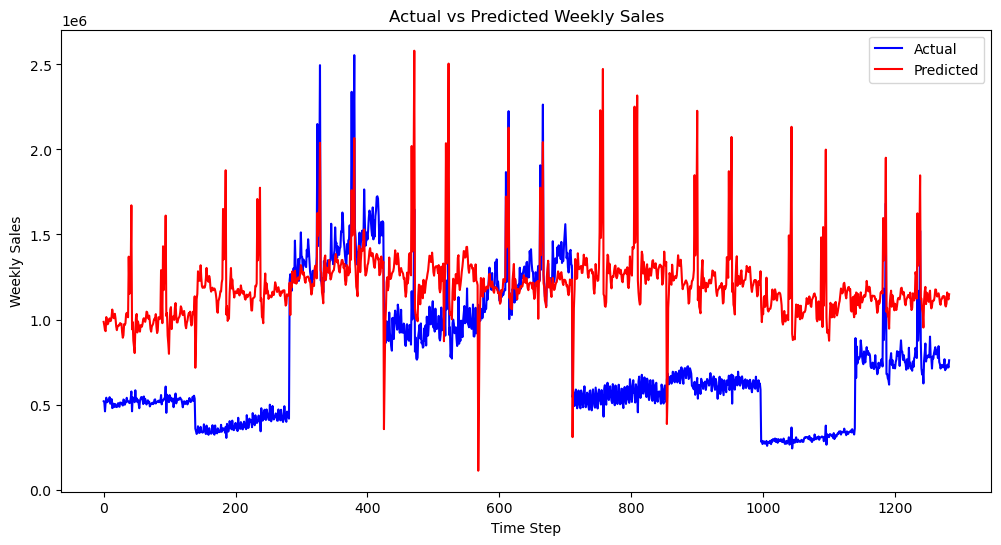

In [99]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Time Step')
plt.ylabel('Weekly Sales')
plt.savefig('Predicted_Sales.png',transparent=True)
plt.show()

## Hyperparameter Tuning

### Define a Function to Build the Model for Hyperparameter Tuning

In [101]:
# Define a function to create the model
def build_model(hp):
    model = Sequential()
    
    # Tune the number of LSTM units in the first LSTM layer
    model.add(LSTM(
        hp.Int('units_1', min_value=32, max_value=128, step=32),  # Hyperparameter to tune
        input_shape=(time_steps, X_train_seq.shape[2]),
        return_sequences=True
    ))
    
    # Add second LSTM layer
    model.add(LSTM(
        hp.Int('units_2', min_value=16, max_value=64, step=16)  # Hyperparameter to tune
    ))
    
    # Add Dropout layer to prevent overfitting
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1))
    
    # Tune the learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

### Define the Hyperparameter Search Space

In [104]:
# Define the tuner using Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # We want to minimize validation loss
    max_trials=10,  # Number of different combinations to try
    executions_per_trial=1,  # Number of trials to run for each combination
    directory='my_dir',  # Directory to save the results
    project_name='LSTM_tuning'
)

### Run the Hyperparameter Search

In [105]:
# Start the hyperparameter search
tuner.search(
    X_train_seq, y_train_seq,  # Training data
    epochs=50,  # Number of epochs to train each model for
    batch_size=32,  # Batch size
    validation_data=(X_test_seq, y_test_seq)  # Validation data
)

Trial 10 Complete [00h 00m 44s]
val_loss: 0.013618209399282932

Best val_loss So Far: 0.012162637896835804
Total elapsed time: 00h 07m 01s


### Get the Best Hyperparameters

In [106]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'units_1': 96, 'units_2': 32, 'dropout_rate': 0.4, 'learning_rate': 2.4203801241730372e-05}


### Train the Final Model with Best Hyperparameters

In [109]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the final model
history = model.fit(
    X_train_seq, y_train_seq, 
    validation_data=(X_test_seq, y_test_seq),
    epochs=50, 
    batch_size=32, 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0829 - mean_absolute_error: 0.2348 - val_loss: 0.0134 - val_mean_absolute_error: 0.0939
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0388 - mean_absolute_error: 0.1530 - val_loss: 0.0155 - val_mean_absolute_error: 0.1099
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0285 - mean_absolute_error: 0.1335 - val_loss: 0.0191 - val_mean_absolute_error: 0.1196
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - mean_absolute_error: 0.1245 - val_loss: 0.0212 - val_mean_absolute_error: 0.1248
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - mean_absolute_error: 0.1165 - val_loss: 0.0220 - val_mean_absolute_error: 0.1267
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0181 - mean_absolute_error: 0.1048 - val_loss: 0.0232 - val_mean_absolute_error: 0.1289


### Final Model Evaluation

In [110]:
# Predict on test data
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Rescale the test target to original scale
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual.flatten(), y_pred.flatten())
rmse = mean_squared_error(y_test_actual.flatten(), y_pred.flatten(), squared=False)

print(f"\n=====Evaluation Metrics=====")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

=====Evaluation Metrics=====
Mean Absolute Error (MAE): 338863.1385629384
Root Mean Squared Error (RMSE): 417045.0503483271


/home/zargiteddy/anaconda3/envs/conda_1/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  # consistently return the same eager evaluated value.


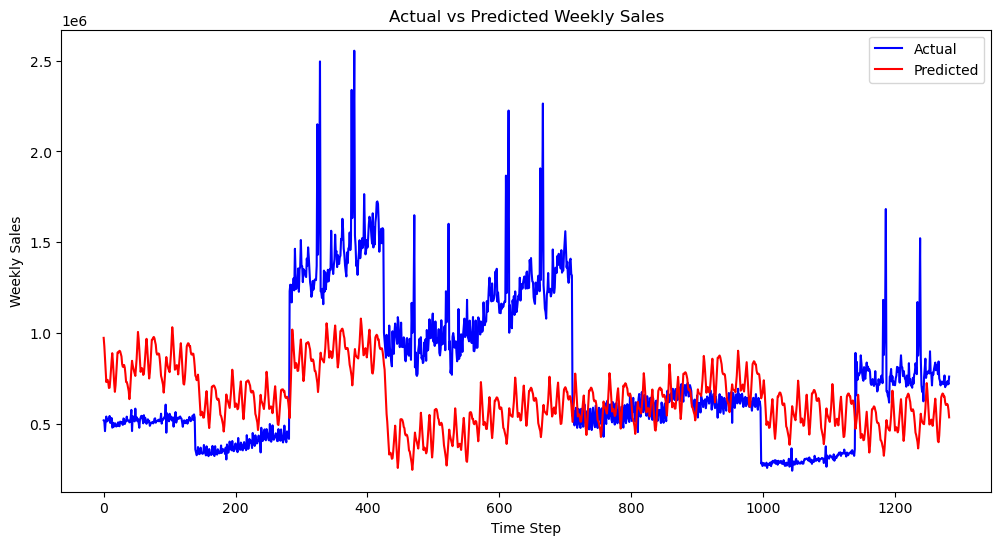

In [111]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Time Step')
plt.ylabel('Weekly Sales')
plt.savefig('Predicted_Sales_2.png',transparent=True)
plt.show()